# Variational simulation study
## Setup

In [1]:
import yaml
import json
import pymc3 as pm
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import sys
import os
import templating
import variational_analysis
import subprocess
import process_results
import pipeline

/usr/lib/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('config.yaml') as f:
    config = yaml.load(f)

config

{'beast_jar': 'lib/feast.jar',
 'burn_in': 0.1,
 'chain_length': 1000000,
 'cluster_type': 'neighborjoining',
 'cluster_with_dates': False,
 'estimate_clock_rate': False,
 'estimate_topology': False,
 'frequencies': [0.24, 0.26, 0.26, 0.24],
 'inference': 'mean_field',
 'init_values': {'clock_rate': 1.0, 'kappa': 2.0, 'pop_size': 1000},
 'kappa': 2.0,
 'log_every': 1000,
 'mutation_rate': 0.001,
 'n_eval_samples': 200,
 'n_iter': 20000,
 'n_runs': 3,
 'n_taxa': 20,
 'n_trace_samples': 1000,
 'nuts_draws': 10000,
 'nuts_tune': 100,
 'out_dir': 'out/0',
 'prior_params': {'clock_rate': {'m': 1.0, 's': 1.25},
  'kappa': {'m': 1.0, 's': 1.25},
  'pop_size': {'m': 2, 's': 0.1}},
 'rate_sd': None,
 'relaxed_clock': False,
 'sampling_window': 20,
 'seed': 1,
 'sequence_length': 1000}

In [3]:
pipeline.do_seeding(config)
out_dir = config['out_dir']
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
build_templates = templating.TemplateBuilder(out_dir)

## Simulation

### Population size

array([6.07391639, 8.98895318])

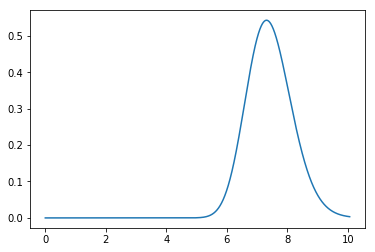

In [4]:
pop_size_prior = scipy.stats.lognorm(scale=np.exp(config['prior_params']['pop_size']['m']), s=config['prior_params']['pop_size']['s'])
xs = np.arange(0, pop_size_prior.ppf(0.999), 0.001)
plt.plot(xs, pop_size_prior.pdf(xs))
pop_size_prior.ppf([0.025, 0.975])

In [5]:
beast_args = ['java'] + pipeline.cmd_kwargs(jar=config['beast_jar'], seed=config['seed']) + ['-overwrite']
pop_size, taxon_names, date_trait_string = build_templates.build_tree_sim(config)
pop_size

8.692273576071088

### Sampling times

18.863292844056232

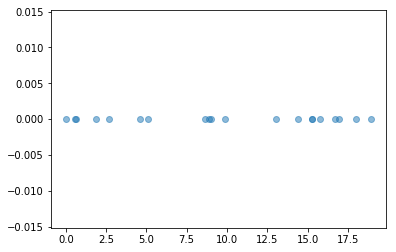

In [6]:
import statsmodels
sampling_times = [float(x.split('=')[1]) for x in date_trait_string.split(',')]
plt.scatter(sampling_times, np.zeros_like(sampling_times), alpha=0.5);
np.max(sampling_times) - np.min(sampling_times)

### Tree simulation

Ran BEAST (out/0/sim-tree.xml) successfully


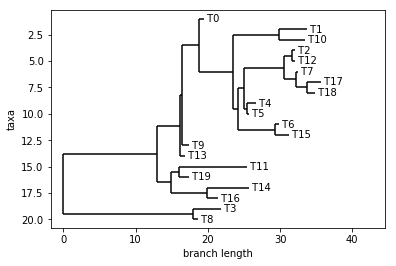

35.67151

In [7]:
import Bio
from io import StringIO

def run_beast(xml_path, **kwargs):
    result = subprocess.run(beast_args + [xml_path], **kwargs)
    if result.returncode != 0:
        print(result.stderr)
        print(result.stdout)
        raise RuntimeError('BEAST run failed')
    else:
        print('Ran BEAST ({0}) successfully'.format(xml_path))
    

run_beast(build_templates.tree_sim_out_path)
newick_string = build_templates.extract_newick_string(build_templates.tree_sim_result_path)
bio_tree = next(Bio.Phylo.parse(StringIO(newick_string), 'newick'))
Bio.Phylo.draw(bio_tree)
tree_height = max(bio_tree.depths().values())
tree_height

In [8]:
run_summary = {
    'config': config,
    'pop_size': pop_size,
    'date_trait_string': date_trait_string,
    'newick_string': newick_string
}

with(open(build_templates.run_summary_path, 'w')) as f:
    yaml.dump(run_summary, f)

### Sequence simulation

In [9]:
build_templates.build_seq_sim(config, taxon_names, newick_string)
run_beast(build_templates.seq_sim_out_path)
sequence_dict = build_templates.extract_sequence_dict()
sequence_values = [pd.Series(list(x)) for x in sequence_dict.values()]
char_counts = pd.concat(sequence_values).value_counts()
char_counts / sum(char_counts)

Ran BEAST (out/0/sim-seq.xml) successfully


A    0.25200
C    0.25085
T    0.24900
G    0.24815
dtype: float64

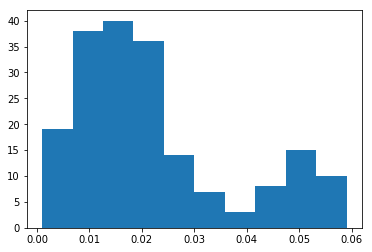

In [10]:
from itertools import combinations

prop_differences = [np.mean(x != y) for x, y in combinations(sequence_values, 2)]
plt.hist(prop_differences);

## Inference

### Cluster tree

Ran BEAST (out/0/cluster-tree.xml) successfully


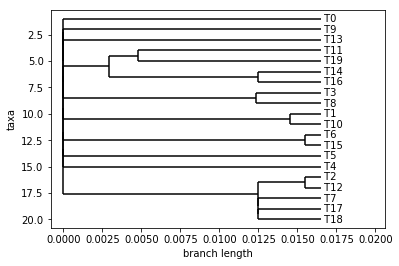

In [11]:
build_templates.build_cluster_tree(config, sequence_dict, date_trait_string)
run_beast(build_templates.cluster_tree_out_path)
cluster_newick_string = build_templates.extract_newick_string(build_templates.cluster_tree_result_path)
bio_cluster_tree = next(Bio.Phylo.parse(StringIO(cluster_newick_string), 'newick'))
Bio.Phylo.draw(bio_cluster_tree)

### TODO: Rooting

In [12]:
analysis_newick = newick_string

### BEAST analysis (estimating tree)

In [13]:
def update_dict(dict, **kwargs):
    res = dict.copy()
    res.update(**kwargs)
    return res

build_templates.build_beast_analysis(update_dict(config, estimate_topology=True), newick_string, date_trait_string, sequence_dict)
run_beast(build_templates.beast_analysis_out_path)

Ran BEAST (out/0/beast-analysis.xml) successfully


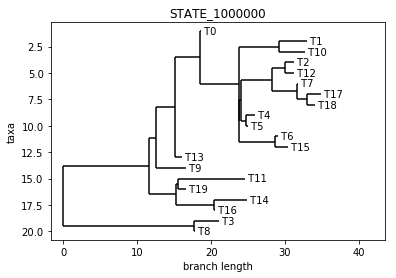

In [14]:
with open(build_templates.beast_analysis_tree_path) as f:
    beast_trees = list(Bio.Phylo.parse(f, 'nexus'))
    
Bio.Phylo.draw(beast_trees[-1])

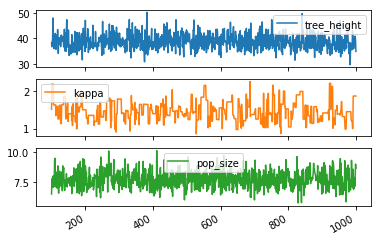

In [15]:
beast_trace_df = process_results.process_beast_trace(build_templates.beast_analysis_trace_path, config)
beast_trace_df.plot(subplots=True);

In [16]:
# TODO: Effective sample size

In [17]:
true_values = {
    'tree_height': tree_height,
    'pop_size': pop_size,
    'kappa': config['kappa']
}

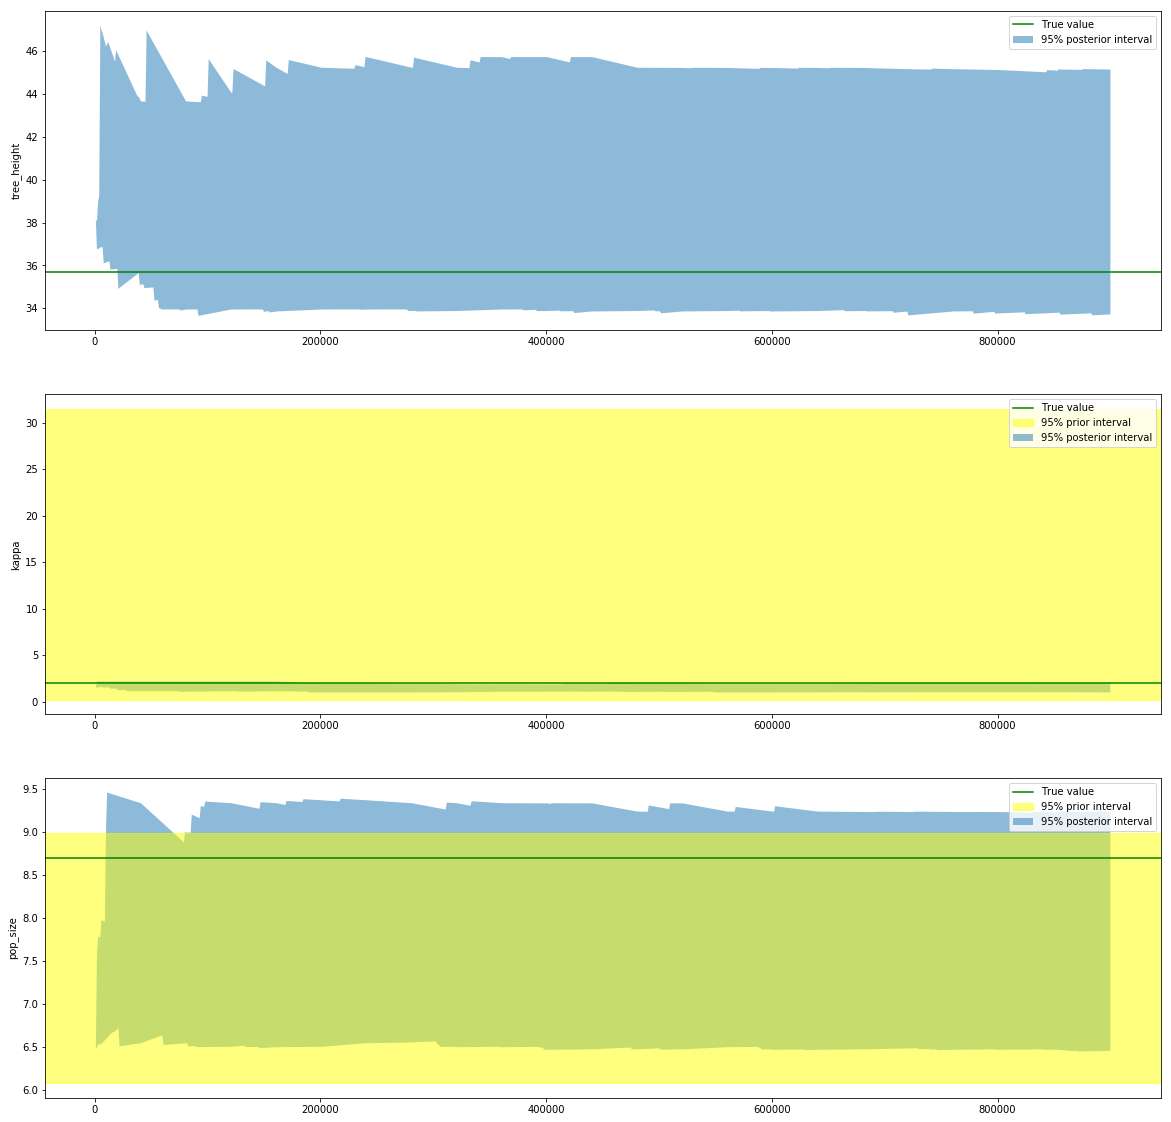

In [23]:
def plot_trace_hpd(trace, xs=None):
    n_cols = trace.shape[1]
    if xs is None:
        xs = np.arange(trace.shape[0])
    fig, axs = plt.subplots(nrows=n_cols, figsize=(20, 20)) 
    p_limits = [0.025, 0.975]
    quantiles = np.stack([np.quantile(trace.values[:i], p_limits, axis=0) for i in range(1, trace.shape[0])])
    for j in range(n_cols):
        ax = axs[j]
        colname = trace.columns[j]
        ax.set_ylabel(colname)
        
        ax.fill_between(xs[1:], quantiles[:, 0, j], quantiles[:, 1, j], alpha=0.5, label='95% posterior interval')
        
        if colname in config['prior_params']:
            prior = scipy.stats.lognorm(scale=np.exp(config['prior_params'][colname]['m']), s=config['prior_params'][colname]['s'])
            ax.axhspan(*prior.ppf(p_limits), color='yellow', alpha=0.5, label='95% prior interval')
        
        ax.axhline(true_values[colname], color='green', label='True value')
        
        ax.legend()
plot_trace_hpd(beast_trace_df, xs=np.arange(beast_trace_df.shape[0])*config['log_every'])